In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,Dropout,Flatten,Dense,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.regularizers import l2

import os
import shutil
import numpy as np
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Check and create directories and classes for valid and test**

In [3]:

# Data path - double check this path in your Google Drive
DATA = '/content/drive/My Drive/Artificial_Intelligence/2-Deep_Learning/CNN/Cats_And_Dogs_Classification/Cat_and_Dogs/'

# Define paths for train, validation, and test directories
directories = {
    "Training": os.path.join(DATA, 'train'),
    "Validation": os.path.join(DATA, 'valid'),
    "Testing": os.path.join(DATA, 'test')
}

# Check and create directories if they do not exist
for dir_name, dir_path in directories.items():
    if not os.path.exists(dir_path):
        print(f"{dir_name} directory not found. Creating the directory...")
        os.makedirs(dir_path)
        print(f"{dir_name} directory created at {dir_path}.")
    else:
        print(f"{dir_name} directory found at {dir_path}.")

# Ensure all classes in train are created in valid and test directories
for phase, phase_dir in directories.items():
    if phase in ["Validation", "Testing"]:
        # Create directories for each class if they don't exist
        for class_name in os.listdir(directories["Training"]):
            class_dir = os.path.join(phase_dir, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
                print(f"Created {class_name} directory in {phase} directory.")

# Access the individual paths from the dictionary
train = directories["Training"]
valid = directories["Validation"]
test = directories["Testing"]


Training directory found at /content/drive/My Drive/Artificial_Intelligence/2-Deep_Learning/CNN/Cats_And_Dogs_Classification/Cat_and_Dogs/train.
Validation directory found at /content/drive/My Drive/Artificial_Intelligence/2-Deep_Learning/CNN/Cats_And_Dogs_Classification/Cat_and_Dogs/valid.
Testing directory found at /content/drive/My Drive/Artificial_Intelligence/2-Deep_Learning/CNN/Cats_And_Dogs_Classification/Cat_and_Dogs/test.


In [4]:


# Print the number of images in each class directory for train, validation, and test
for phase, phase_dir in directories.items():
    print(f"\n{phase} Directory:")

    for class_name in os.listdir(phase_dir):
        class_dir = os.path.join(phase_dir, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            num_images = len(os.listdir(class_dir))
            print(f"  {class_name}: {num_images} images")



Training Directory:
  Dog: 10008 images
  Cat: 10004 images

Validation Directory:
  Dog: 1250 images
  Cat: 1250 images

Testing Directory:
  Dog: 1251 images
  Cat: 1250 images


## **Split Data to test and valid**

In [5]:
# Function to check if all class directories in valid and test are empty

def check_class_directories_empty(directories):
    all_empty = True
    class_names = os.listdir(directories["Training"])

    for phase, phase_dir in directories.items():
        if phase in ["Validation", "Testing"]:
            for class_name in class_names:
                class_dir = os.path.join(phase_dir, class_name)
                if os.path.exists(class_dir) and os.listdir(class_dir):  # Check if directory exists and is not empty
                    all_empty = False
                    break
            if not all_empty:
                break

    return all_empty



    # Check if all class directories in valid and test are empty
if check_class_directories_empty(directories):
    print("All class directories in valid and test are empty.")
else:
    print("Not all class directories in valid and test are empty.")


Not all class directories in valid and test are empty.


In [6]:

# Split ratio
train_split = 0.8  # 80% for the train set
valid_split = 0.5  # 50% of the remaining 20% for valid and 50% for the test


# Function to move files
def move_files(source, dest, split_ratio):
    files = os.listdir(source)
    np.random.shuffle(files)  # Shuffle the files to ensure randomness
    split_size = int(len(files) * split_ratio)
    for file in files[:split_size]:
        shutil.move(os.path.join(source, file), os.path.join(dest, file))

    print(f"Moved {split_size} files from {source} to {dest}")




    # Check if all class directories in valid and test are empty
if check_class_directories_empty(directories):
    print("All class directories in valid and test are empty.")

    # Iterate over each class in the train directory
    for class_name in os.listdir(directories["Training"]):
        class_train_dir = os.path.join(directories["Training"], class_name)
        class_test_dir = os.path.join(directories["Testing"], class_name)
        class_valid_dir = os.path.join(directories["Validation"], class_name)


        # Move 20% of the files from train to test set
        move_files(class_train_dir, class_test_dir, 1-train_split)

        # Move 50% of the files from test to valid set (10% of the total)
        move_files(class_test_dir, class_valid_dir, valid_split)

else:
    print("Validation or Test class directories already contain files. Split has already been performed or needs to be done manually.")




Validation or Test class directories already contain files. Split has already been performed or needs to be done manually.


In [7]:


# Print the number of images in each class directory for train, validation, and test
for phase, phase_dir in directories.items():
    print(f"\n{phase} Directory:")

    for class_name in os.listdir(phase_dir):
        class_dir = os.path.join(phase_dir, class_name)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            num_images = len(os.listdir(class_dir))
            print(f"  {class_name}: {num_images} images")



Training Directory:
  Dog: 10008 images
  Cat: 10004 images

Validation Directory:
  Dog: 1250 images
  Cat: 1250 images

Testing Directory:
  Dog: 1251 images
  Cat: 1250 images


In [8]:

def copy_half_samples(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for class_name in os.listdir(source_dir):
        class_source_dir = os.path.join(source_dir, class_name)
        class_destination_dir = os.path.join(destination_dir, class_name)

        if not os.path.exists(class_destination_dir):
            os.makedirs(class_destination_dir)

        files = os.listdir(class_source_dir)
        num_files = len(files)
        num_to_copy = num_files // 4  # division the number of files

        random.shuffle(files)  # Shuffle files for random selection

        for file in files[:num_to_copy]:
            source_file_path = os.path.join(class_source_dir, file)
            destination_file_path = os.path.join(class_destination_dir, file)
            shutil.copy(source_file_path, destination_file_path)

train_copy = os.path.join(DATA, 'quarter/train_copy')
valid_copy = os.path.join(DATA, 'quarter/valid_copy')
test_copy = os.path.join(DATA, 'quarter/test_copy')

copy_half_samples(train, train_copy)
copy_half_samples(valid, valid_copy)
copy_half_samples(test, test_copy)

train = train_copy
valid = valid_copy
test = test_copy


print(len(os.listdir(train)))
print(len(os.listdir(valid)))
print(len(os.listdir(test)))


2
2
2


In [9]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Number of images to display per class per directory
num_images_to_display = 10

# Iterate through each directory (train, validation, test)
for phase, phase_dir in directories.items():
    print(f"\nDisplaying images from {phase} directory:")

    # Iterate through each class (Cat, Dog)
    for class_name in os.listdir(phase_dir):
        class_dir = os.path.join(phase_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = os.listdir(class_dir)[:num_images_to_display]

            # Create a figure and axes for the images
            fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))

            # Display each image
            for i, image_file in enumerate(image_files):
                image_path = os.path.join(class_dir, image_file)
                image = mpimg.imread(image_path)
                axes[i].imshow(image)
                axes[i].axis('off')  # Turn off axis labels
                axes[i].set_title(class_name)  # Set title as class name

            plt.show()


Output hidden; open in https://colab.research.google.com to view.

## **Remove Image Error**

In [10]:
"""from PIL import Image, UnidentifiedImageError

# Iterate through each directory (train, validation, test)
for phase, phase_dir in directories.items():
    print(f"\nChecking images in {phase} directory:")

    # Iterate through each class (Cat, Dog)
    for class_name in os.listdir(phase_dir):
        class_dir = os.path.join(phase_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = os.listdir(class_dir)

            # Check each image
            for image_file in image_files:
                image_path = os.path.join(class_dir, image_file)
                try:
                    img = Image.open(image_path)  # Attempt to open the image
                except UnidentifiedImageError:
                    print(f"UnidentifiedImageError: {image_path}")
                    # Optionally, you can delete the corrupted image
                    # os.remove(image_path)"""


'from PIL import Image, UnidentifiedImageError\n\n# Iterate through each directory (train, validation, test)\nfor phase, phase_dir in directories.items():\n    print(f"\nChecking images in {phase} directory:")\n\n    # Iterate through each class (Cat, Dog)\n    for class_name in os.listdir(phase_dir):\n        class_dir = os.path.join(phase_dir, class_name)\n        if os.path.isdir(class_dir):\n            image_files = os.listdir(class_dir)\n\n            # Check each image\n            for image_file in image_files:\n                image_path = os.path.join(class_dir, image_file)\n                try:\n                    img = Image.open(image_path)  # Attempt to open the image\n                except UnidentifiedImageError:\n                    print(f"UnidentifiedImageError: {image_path}")\n                    # Optionally, you can delete the corrupted image\n                    # os.remove(image_path)'

In [11]:
# parameters
image_size = 150
image_channel = 3
bat_size = 32

In [12]:

# Data augmentation and rescaling for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Rescaling for validation and test sets
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(image_size, image_size),  # Resize images to the desired size
    batch_size=bat_size,
    class_mode='binary'
)

# Validation data generator
validation_generator = valid_test_datagen.flow_from_directory(
    valid,
    target_size=(image_size, image_size),
    batch_size=bat_size,
    class_mode='binary'
)

# Test data generator
test_generator = valid_test_datagen.flow_from_directory(
   test,
   target_size=(image_size, image_size),
   batch_size=bat_size,
   class_mode='binary'
)

print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)
print("Number of classes:", len(train_generator.class_indices))
print("Class indices:", train_generator.class_indices)

Found 5003 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Number of training samples: 5003
Number of validation samples: 624
Number of test samples: 624
Number of classes: 2
Class indices: {'Cat': 0, 'Dog': 1}


In [13]:

import matplotlib.pyplot as plt
# Get images and labels from the generators
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch =next(validation_generator)
x_test_batch, y_test_batch = next(test_generator)

# Plot images from each generator
def plot_images(images, labels, title):
  plt.figure(figsize=(15,5))
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}") # Assuming binary labels (0 or 1)
    plt.axis('off')
  plt.suptitle(title)
  plt.show()

plot_images(x_train_batch, y_train_batch, "Training Images")
plot_images(x_valid_batch, y_valid_batch, "Validation Images")
plot_images(x_test_batch, y_test_batch, "Test Images")


Output hidden; open in https://colab.research.google.com to view.

In [23]:
    model = Sequential()

    # Input Layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',input_shape=(image_size, image_size, image_channel), kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Block 1
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Block 2
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Block 3
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Block 4
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Print the model summary
    model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 29, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 256)           │              

 Total params: 5,762,433 (21.98 MB)

 Trainable params: 5,757,505 (21.96 MB)

 Non-trainable params: 4,928 (19.25 KB)

# **Callbacks**
we will be using two callbacks

**1-ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.

**2- Stop training** when a monitored metric has stopped improving.

In [24]:
# Callbacks setup
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 5 epochs with no improvement
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

"""
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)



checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
"""

"\nlearning_rate_reduction = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.2,\n    patience=3,\n    min_lr=0.00001,\n    verbose=1\n)\n\n\n\ncheckpoint = ModelCheckpoint(\n    'best_model.keras',\n    monitor='val_accuracy',\n    mode='max',\n    save_best_only=True,\n    verbose=1\n)\n"

# **Compile the model**
**1-Optimizer :-** To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.​

**2-Loss :-** To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.​


**3-Metrics :-**This is to denote the measure of your model. Can be accuracy or some other metric.

In [25]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


# Optimizer
optimizer = Adam(learning_rate=0.0001)

# Recompile the model with the new optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#model.compile(optimizer='adam',loss='binary_crossentropyy',metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(optimizer=RMSprop(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])


## **Fit the model**
The number of steps for the train and validation iterators must be specified.
 This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the **total number of images in the train and validation directories divided by the batch size (32)**.

The model will be fit for **30 epochs**.

In [26]:
fraction = 1  # reducing
epochs=20


# Train the model
history = model.fit(
    train_generator,  # The training data generator
    steps_per_epoch=int(fraction * (train_generator.samples // train_generator.batch_size)),   #(20000/32) Number of steps per epoch (batches of data)
    epochs=epochs,  # Set maximum number of epochs to 30
    validation_data=validation_generator,  # The validation data generator
    validation_steps=int(fraction * (validation_generator.samples // validation_generator.batch_size)),  #(2500/32) Number of validation steps per epoch
    callbacks=[early_stopping],  # Include early stopping and learning rate reduction callbacks


    # verbose=2  # Verbose mode (2 = one line per epoch, showing key metrics)
)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 832s 5s/step - accuracy: 0.5608 - loss: 1.1882 - val_accuracy: 0.4984 - val_loss: 1.3840
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6250 - loss: 0.9906 - val_accuracy: 0.5625 - val_loss: 1.2383
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 879s 5s/step - accuracy: 0.6136 - loss: 1.0740 - val_accuracy: 0.5033 - val_loss: 1.2412
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5625 - loss: 1.0698 - val_accuracy: 0.3750 - val_loss: 1.3796
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.6211 - loss: 1.0338 - val_accuracy: 0.5181 - val_loss: 1.5174
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.5312 - loss: 1.3714 - val_accuracy: 0.8125 - val_loss: 0.8693
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 853s 5s/step - accuracy: 0.6354 - loss: 1.0085 - val_accuracy: 0.6595 - val_loss: 0.9376
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6875 - loss: 0.9359 - val_accu

In [27]:

from google.colab import files

model.save('my_model.h5')
files.download('my_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# load the model

from tensorflow.keras.models import load_model

model = load_model('my_model.h5')


In [29]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7028 - loss: 0.8763
Test Loss: 0.8339377045631409
Test Accuracy: 0.7083333134651184


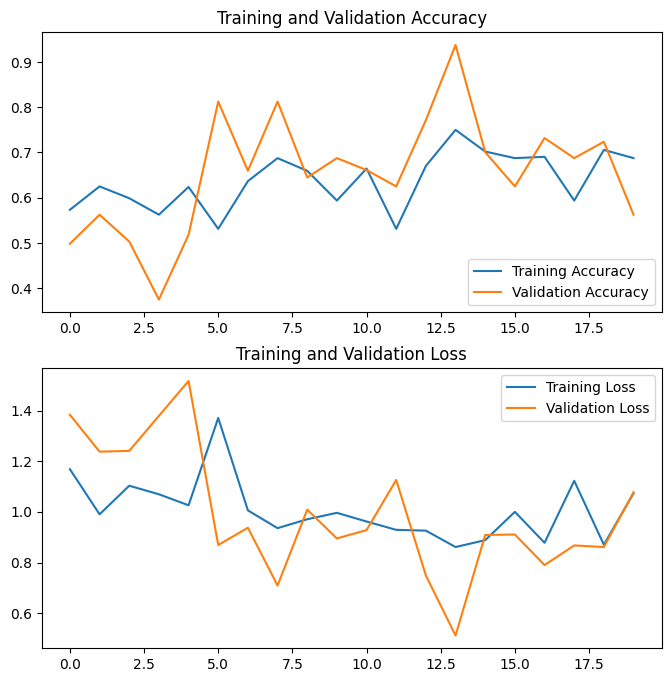

In [30]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## **Predictions Test Generator**

In [31]:
# Get predictions for the test set
predictions = model.predict(test_generator)

# Print the range of predicted probabilities
print("Range of predicted probabilities:", predictions.min(), predictions.max())


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
Range of predicted probabilities: 0.00030299593 0.9999544


In [32]:

# Print predicted probabilities for each image in the test set
for i in range(len(predictions)):
    predicted_probability = predictions[i][0]
    predicted_class = "Dog" if predicted_probability >= 0.5 else "Cat"
    print(f"Image {i+1}: Predicted Probability = {predicted_probability:.4f}, Predicted Class = {predicted_class}")




Image 1: Predicted Probability = 0.0580, Predicted Class = Cat
Image 2: Predicted Probability = 0.4359, Predicted Class = Cat
Image 3: Predicted Probability = 0.1439, Predicted Class = Cat
Image 4: Predicted Probability = 0.0460, Predicted Class = Cat
Image 5: Predicted Probability = 0.3932, Predicted Class = Cat
Image 6: Predicted Probability = 0.0770, Predicted Class = Cat
Image 7: Predicted Probability = 0.5610, Predicted Class = Dog
Image 8: Predicted Probability = 0.5628, Predicted Class = Dog
Image 9: Predicted Probability = 0.2849, Predicted Class = Cat
Image 10: Predicted Probability = 0.7623, Predicted Class = Dog
Image 11: Predicted Probability = 0.6148, Predicted Class = Dog
Image 12: Predicted Probability = 0.8588, Predicted Class = Dog
Image 13: Predicted Probability = 0.0343, Predicted Class = Cat
Image 14: Predicted Probability = 0.6693, Predicted Class = Dog
Image 15: Predicted Probability = 0.8317, Predicted Class = Dog
Image 16: Predicted Probability = 0.0417, Predict

## **Accuracy of  Test Predictions**

In [33]:
from sklearn.metrics import accuracy_score

# Threshold for classification
threshold = 0.5

# Convert predictions to binary classes
predicted_classes = (predictions >= threshold).astype(int)

# Get true labels from the test generator
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f"Accuracy of predictions: {accuracy * 100:.2f}%")

Accuracy of predictions: 47.44%


# **Classification of external Images**

In [35]:
from keras.preprocessing import image
# Function to load and preprocess a single image
def preprocess_image(image_path):
  img = image.load_img(image_path, target_size=(image_size, image_size))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
  img_array /= 255.0  # Rescale pixel values
  return img_array

# Path to your new image
new_image_path = 'download.jpeg'  # Replace with the actual path

# Preprocess the image
img_array = preprocess_image(new_image_path)

# Make a prediction
predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions)

# Get the class labels from the generator
class_labels = list(train_generator.class_indices.keys())

predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)
print("Predictions:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: Cat
Predictions: [[0.53408325]]
